### Normal Squares, toggleable features 
-   This code creates a series of squares around the all exterior contours of a cell, normal to its outline, that can then be extracted into images
-   second_pass and variable_length can be toggled for additional overlap accuracy and varying lenghts of squares, respectively
    - There is also now a score and grid search for optimization of coverage and minimization of excess blank pixels over the patching

### Basic Algorithm Outline:

-   Begin by extracting all external contours of a thresholded image
-   Then for every point along the contours, find a tangent point and use that to calculate the normal vector "into" the cell
-   Use these vectors and set square size or an iterative approach (variable_length=True/False) to find the length, from epithelium width, and corners of many squares along the contour
    - This is currenlty done by creating a square at every set step rate and checking these for overlap against each other
-   Overlapping squares are checked and removed, a second pass checks all remaining squares as the first checks only the last x created squares
-   The remaining squares are stored and drawn on the origianl image


-   There is also an evaluation score that checks total coverage of the epithelium and number of blank pixles in the created mask, which can be used to tune hyperparameters in a GrdiSearch
    - Further refined approaches to creation and selection may not require this step as the model is currently parameter sensitive

In [5]:
import numpy as np
import cv2
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid


#Read image and threshold for mask:
#This basic method works best with already cropped cells
#I have another at the bottom that is slightly better for cells with backgrounds
image1=cv2.imread("h2114153  h&e_ROI_1 Epithelia.png")





image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
_,whole_thresh=cv2.threshold(image1_gray,1,255,cv2.THRESH_BINARY)


In [39]:
def find_external_contours(binary_image):
    '''find all external contours of an image'''

    contours,hierarchy=cv2.findContours(binary_image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #print(len(contours[0]))
    return contours

def calculate_contour_normals(contours,smoothing_size=5):
    '''Calculate normal vector along contour points'''

    all_normals=[]
    
    #Loop over all contours in image
    for contour in contours:
        #Reshape into xy pairings
        points=contour.reshape(-1,2)
        n_points=len(points)
        tangents=np.zeros_like(points,dtype=float)

        #Calculate tangent using smoothing
        for i in range(n_points):
            prev_idx=(i-smoothing_size)%n_points
            next_idx=(i+smoothing_size)%n_points
            tangent=points[next_idx]-points[prev_idx]
            tangent=tangent/(np.linalg.norm(tangent)+1e-8)
            tangents[i]=tangent
            

        #Convert to normal
        normals=np.zeros_like(tangents)
        normals[:,0]=-tangents[:,1]
        normals[:,1]=tangents[:,0]
        
        #add to list of all contour normals
        all_normals.append(normals)

    return all_normals

def calculate_square_corners(point,normal,square_size,binary_image,variable_length=True):
    '''Calculate corners of square normal to point'''

    tangent=np.array([-normal[1],normal[0]])
    half_size=square_size//2
    extended_length=square_size

    #Loop to find variable length
    if variable_length:
        i=square_size
        while True:
            #Increase i while extending into cell
            test_point=point-(normal*i).astype(int)
            test_point=np.clip(test_point,0,np.array(binary_image.shape[:2])[::-1] - 1)

            if binary_image[test_point[1],test_point[0]]==0:
                break
            #if i>=1024:
            #    break #Maximum square size as to not be huge
            i+=10

        extended_length=i
        half_size=i//2

    corners=np.array([
        point+(tangent*half_size),
        point-(tangent*half_size),
        point-(tangent*half_size)-(normal*extended_length),
        point+(tangent*half_size)-(normal*extended_length)
    ])
    

    return corners,extended_length

def calculate_square_overlap(square1,square2):
    '''Calculate overlap ratio between squares'''

    square1=Polygon(square1)
    square2=Polygon(square2)

    if not square1.intersects(square2):
        return 0
    
    intersection_area=square1.intersection(square2).area
    smallest_area=min(square1.area,square2.area)
    return intersection_area/smallest_area

def create_dense_squares(contours,normals,binary_image,square_size=128,step=5,variable_length=True):
    '''Create many squares along external contours at regular interval'''

    all_squares=[]


    #Loop over all contours 
    for contour,contour_normals in zip(contours, normals):
        points=contour.reshape(-1,2)
        n_points=len(points)
        squares=[]

        #Find corners at step length
        for i in range(0,n_points,step):
            corners,length=calculate_square_corners(points[i],contour_normals[i],square_size,binary_image,variable_length)

            if length>=2048 or length<16: #Trying to avoid badly sized squares
                continue

            squares.append(corners)

        all_squares.append(squares)
    return all_squares


def create_smarter_squares(contours,normals,binary_image,square_size,variable_length=True):
    '''Create squares spaced by at least the width of the last square'''
    return_squares=[]

    #Loop over all contours and get corresponding normals to point
    for contour, contour_normals in zip(contours,normals):
        points=contour.reshape(-1,2)
        squares=[]

        #Go over points, evaluating if next square's corner falls outside of range of last square
        for i,point in enumerate(points):
            corners,length=calculate_square_corners(point,contour_normals[i],square_size,binary_image,variable_length)
            top_left=corners[1]
            top_right=corners[0]
            if i==0:
                squares.append(corners)
                last_left=top_left
                last_length=length
                continue
            elif (np.linalg.norm(top_right-last_left))>=last_length//2:
                squares.append(corners)
                last_left=top_left
                last_length=length
                continue
            else:
                continue
        return_squares.append(squares)
    return return_squares


def create_smarter_squares_2(contours,normals,binary_image,square_size,overlap_thresh,variable_length=True):
    '''Create squares spaced by at least the width of the last square'''
    return_squares=[]

    #Loop over all contours and get corresponding normals to point
    for contour, contour_normals in zip(contours,normals):
        points=contour.reshape(-1,2)
        squares=[]

        #Go over points, evaluating if next square's corner falls outside of range of last square
        for i,point in enumerate(points):
            corners,length=calculate_square_corners(point,contour_normals[i],square_size,binary_image,variable_length)
            current_square=corners
            if i==0:
                squares.append(current_square)
                last_square=current_square
                continue
            elif calculate_square_overlap(current_square,last_square)<=overlap_thresh:
                squares.append(current_square)
                continue
            else:
                continue
        return_squares.append(squares)
    return return_squares



def remove_overlapping_squares(all_squares, overlap_thresh=0.3, look_back=5, second_pass=True):
    final_squares_list = []

    # First pass: remove overlaps within each contour
    for squares in all_squares:
        # Keep first square
        kept_squares = [squares[1]]

        # Check squares within the same contour
        for i in range(1, len(squares)):
            overlap_found = False
            current_square = squares[i]

            # Check within look_back in same contour
            for j in range(max(0, len(kept_squares) - look_back), len(kept_squares)):
                overlap = calculate_square_overlap(current_square, kept_squares[j])
                if overlap > overlap_thresh:
                    overlap_found = True
                    break

            if not overlap_found:
                kept_squares.append(current_square)
        
        final_squares_list.append(kept_squares)

    # Second pass: check against ALL squares across ALL contours
    if second_pass:
        # Flatten all squares
        all_squares_flattened=[square for contour_squares in final_squares_list for square in contour_squares]
        final_refined_squares_list=[]

        # Check each contour's squares
        for contour_squares in final_squares_list:
            refined_squares=[]

            # Check each square against ALL other squares
            for square in contour_squares:
                overlap_found=False
                
                # Check against all flattened squares
                for other_square in all_squares_flattened:
                    if not np.array_equal(square, other_square):
                        overlap=calculate_square_overlap(square, other_square)
                        if overlap>overlap_thresh:
                            overlap_found=True
                            break
                
                # Only add if no significant overlap found
                if not overlap_found:
                    refined_squares.append(square)
            
            final_refined_squares_list.append(refined_squares)

        return final_refined_squares_list

    return final_squares_list

def draw_squares(image,squares_list,color=[255,0,0],thickness=20):
    '''Draw squares on image'''

    result=image.copy()

    for squares in squares_list:
        for square in squares:
            points=square.astype(np.int32)
            cv2.polylines(result,[points],isClosed=True,color=color,thickness=thickness)
        
    return result



def process_contours(image,binary_image,square_size=128,step=5,overlap_thresh=0.3,
                    smoothing_size=5,look_back=3,second_pass=True,variable_length=False):
    """
    Main function to process multiple contours and generate aligned squares along them.
    
    Args:
        image (np.ndarray): Original image
        binary_image (np.ndarray): Binary mask of the shapes
        square_size (int): Base size of squares
        step (int): Points to skip between squares
        overlap_thresh (float): Maximum allowed overlap between squares
        smoothing_size (int): Points to consider for normal calculation
        look_back (int): Squares to check for overlap
        second_pass (bool): Whether to do precise overlap checking
        variable_length (bool): Whether to use variable length squares
        
    Returns:
        tuple: (processed image, contours, squares_list)
    """
    contours=find_external_contours(binary_image)
    if not contours:
        return TypeError('No contours found')
    
    
    normals=calculate_contour_normals(contours,smoothing_size)
    squares_list=create_smarter_squares_2(
        contours,normals,binary_image,overlap_thresh=overlap_thresh,
        square_size=square_size,
        variable_length=variable_length
    )
    
    final_squares_list=remove_overlapping_squares(
        squares_list,
        overlap_thresh=overlap_thresh,
        look_back=look_back,
        second_pass=second_pass
    )    
    result = draw_squares(image,final_squares_list)
    #plt.imshow(result)
    
    return result, contours, final_squares_list





In [40]:
def check_metrics(binary_image,contours):
    '''Evaluate fit of normal squares using mask'''

    total_white_pixels=(binary_image>0).sum()
    squares_mask=np.zeros_like(binary_image,dtype=np.uint8)

    weight_coverage=0.8
    weight_black_pixels=0.2
    #For all squares in all contours, use them to create a mask
    for contour in contours:
        for square in contour:
            square=np.array(square,dtype=np.int32).reshape(-1,1,2)
            cv2.fillPoly(squares_mask,[square],255)

    mask_pixels=np.count_nonzero(squares_mask>0)
    #Find coverage and non-epitheliuem pixel values 
    covered_white_pixels=np.count_nonzero((squares_mask>0)&(binary_image>0))
    covered_black_pixels=np.count_nonzero((squares_mask>0)&(binary_image==0))

    total_coverage=(covered_white_pixels/total_white_pixels*100)
    black_pixel_percent=(covered_black_pixels/mask_pixels*100)
    score=weight_coverage*total_coverage+weight_black_pixels*(100-black_pixel_percent)
    
    return total_coverage,black_pixel_percent,score
        


In [41]:
def search_params(param_grid,binary_image,image,overlap_thresh=0.05):
    '''Grid Search to find best parameters for normal squares'''
    best_params=[]
    best_result=None

    for params in param_grid:
        square_size=params['square_size']
        step=params['step']
        smoothing_size=params['smoothing_size']
        look_back=params['look_back']

        _,_,squares_test=process_contours(image,binary_image,square_size,step,overlap_thresh=0,
                                          smoothing_size=smoothing_size,look_back=look_back,second_pass=True, variable_length=True)

        coverage,black_percent,score=check_metrics(binary_image,squares_test)

        if best_result is None or score>best_result[2]:
            best_result=(coverage,black_percent,score)
            best_params=params

    step=best_params['step']
    look_back=best_params['look_back']

    result_image,best_contours,best_squares=process_contours(image,binary_image,square_size=best_params['square_size'],
                                                step=best_params['step'],overlap_thresh=overlap_thresh,smoothing_size=best_params['smoothing_size'],
                                                look_back=best_params['look_back'],second_pass=True,variable_length=True)
    print(f"Best Parameters: {best_params}")
    print(f"Best Total Coverage: {best_result[0]:.2f}%")
    print(f"Best Black Pixel Percentage: {best_result[1]:.2f}%")
    print(f"Best Score Percentage: {best_result[2]:.2f}%")

    plt.imshow(result_image)
    return result_image,best_contours,best_squares

param_grid=ParameterGrid({'square_size':[4],'look_back':[8,18,30,50,70],'step':[3,8,30,50,72],'smoothing_size':[150,30,100,120,200]})
search_params(param_grid,whole_thresh,image1,overlap_thresh=0.07);

Coverage: 62.54%, Percent of mask as blank pixels: 11.33%, Score: 67.76%


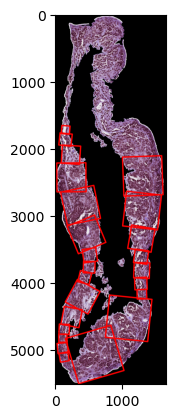

In [50]:
result_image, contour, squares = process_contours(
     image1,
     whole_thresh,
     square_size=32,
     step=30,
     overlap_thresh=0.07,
     smoothing_size=180,
     look_back=20,
     second_pass=False,
     variable_length=True)

plt.imshow(result_image)

coverage,perc_black_pixels,score=check_metrics(whole_thresh,squares)
print(f'Coverage: {coverage:.2f}%, Percent of mask as blank pixels: {perc_black_pixels:.2f}%, Score: {score:.2f}%')

Coverage: 45.77%, Percent of mask as blank pixels: 8.97%, Score: 54.82%


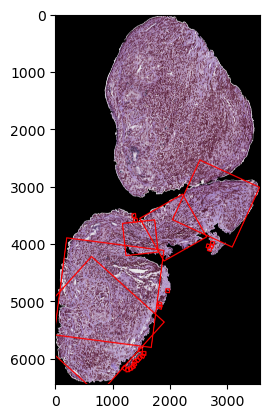

In [49]:
image2=cv2.imread("h2114160 h&e_ROI_1 Epithelia.png")

image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
_,whole_thresh2=cv2.threshold(image2_gray,1,255,cv2.THRESH_BINARY)
result_image2, contour2, squares2 = process_contours(
     image2,
     whole_thresh2,
     square_size=64,
     step=250,
     overlap_thresh=0.2,
     smoothing_size=300,
     look_back=200,
     second_pass=False,
     variable_length=True)

plt.imshow(result_image2)
coverage,perc_black_pixels,score=check_metrics(whole_thresh2,squares2)
print(f'Coverage: {coverage:.2f}%, Percent of mask as blank pixels: {perc_black_pixels:.2f}%, Score: {score:.2f}%')

Coverage: 59.49%, Percent of mask as blank pixels: 26.24%, Score: 62.34%


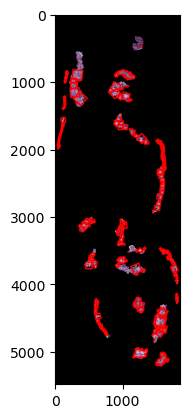

In [57]:
image3=cv2.imread("h2114154  h&e_ROI_4 Epithelia.png")
image3_gray = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
_,whole_thresh3=cv2.threshold(image3_gray,1,255,cv2.THRESH_BINARY)
result_image3, contour3, squares3 = process_contours(
     image3,
     whole_thresh3,
     square_size=4,
     step=10,
     overlap_thresh=0.2,
     smoothing_size=140,
     look_back=20,
     second_pass=False,
     variable_length=True)
plt.imshow(result_image3)
coverage,perc_black_pixels,score=check_metrics(whole_thresh3,squares3)
print(f'Coverage: {coverage:.2f}%, Percent of mask as blank pixels: {perc_black_pixels:.2f}%, Score: {score:.2f}%')

Coverage: 19.17%, Percent of mask as blank pixels: 16.04%, Score: 32.12%


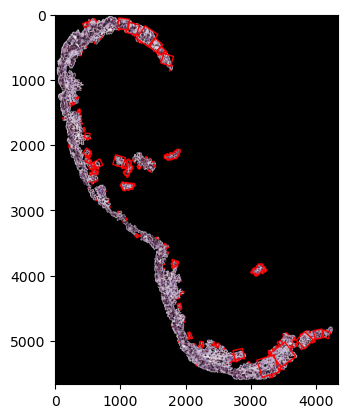

In [59]:
image4=cv2.imread("h2114155 h&e_ROI_1 Epithelia.png")
image4_gray = cv2.cvtColor(image4, cv2.COLOR_BGR2GRAY)
_,whole_thresh4=cv2.threshold(image4_gray,1,255,cv2.THRESH_BINARY)
result_image4, contour4, squares4 = process_contours(
     image4,
     whole_thresh4,
     square_size=4,
     step=10,
     overlap_thresh=0.07,
     smoothing_size=150,
     look_back=75,
     second_pass=True,
     variable_length=True)

plt.imshow(result_image4)
coverage,perc_black_pixels,score=check_metrics(whole_thresh4,squares4)
print(f'Coverage: {coverage:.2f}%, Percent of mask as blank pixels: {perc_black_pixels:.2f}%, Score: {score:.2f}%')